<a href="https://colab.research.google.com/github/DAVIDCRUZ0202/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_224_assignment_David_cruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. and Make sure val is the same size as test
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),
                             stratify=train[target], random_state=42)

In [3]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [4]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """ How are we going to wrangle our train val test sets?"""
    
    X = X.copy()
    
    # Convert the dates into datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # extract the components from date_recorded, and drop the original column to remove duplicates
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer a new feature: How many years from construction year to date_recorded?
    X['years'] = X['year_recorded'] - X['construction_year']
    
    # Drop recorded_by ( only 1 value, it never varies)
    # and drop id (always varies, random number)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop more duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # Let's replace outlier values. when inspecting Latitude,
    # we see that some values are near zero which means they're
    # outside of Tanzania so we'll replace
    # their values with null values.
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When comlumns have zeros and shouldn't they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

# This wrangle function can be modified and adjusted so that we further clean
# and engineer our features, before splitting them into test/val/train splits.

## We already did our splits in the cell above. Let's make sure the shapes are good
## and then we will make them into feature matrixes and target vectors.
## After features and targets have been defined, we can make a pipeline.

# train.shape, val.shape, test.shape

# The shapes look good. Lets arrange them into proper matrices and vectors, and
# build the pipeline.

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# make pipeline
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Validation Accuracy 0.8130658866137345


In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
## This is how we apply our wrangling to the data set. The FunctionTransformer
## Will take our function, and apply it as a transformer to all things passed into
## the pipeline. FunctionTransformer takes the function argument as X, and then a couple
## of other optionals.
FunctionTransformer?

In [0]:
## Checking the help for RandomForestClassifier gives us some good background knowledge.
## n_estimators is the number of trees in our model.
RandomForestClassifier?

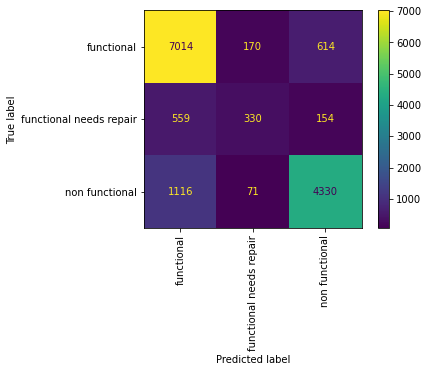

In [7]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [0]:
submission = sample_submission.copy()

submission['status_group'] = y_pred

submission.to_csv('dc_try4.csv', index=False)

In [0]:
from google.colab import files
files.download('dc_try4.csv')